<a href="https://colab.research.google.com/github/ahammedshaneebnk/AI_2025/blob/main/ANN/2025_003_Image_Classification_with_ANN_on_FashionMNIST_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries

In [28]:
%pip install torch_summary

In [29]:
import torch
import torch.nn         as     nn
from   torch.utils.data import Dataset, DataLoader
from   torch.optim      import SGD

import numpy as np

from matplotlib import pyplot as plt

from torchvision import datasets

from torchsummary import summary

#Device Selection

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device

'cuda'

#Dataset: Fashion MNIST

In [3]:
local_dataset_folder = "shaneeb/data/FMNIST" #anything

# Download
fmnist_train = datasets.FashionMNIST(root=local_dataset_folder, train=True, download=True)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.7MB/s]


Extracting shaneeb/data/FMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to shaneeb/data/FMNIST/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 200kB/s]


Extracting shaneeb/data/FMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to shaneeb/data/FMNIST/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.74MB/s]


Extracting shaneeb/data/FMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to shaneeb/data/FMNIST/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 6.01MB/s]

Extracting shaneeb/data/FMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to shaneeb/data/FMNIST/FashionMNIST/raw



In [7]:
train_images = fmnist_train.data
train_labels = fmnist_train.targets

In [5]:
train_images.shape

torch.Size([60000, 28, 28])

In [8]:
train_labels.shape

torch.Size([60000])

In [10]:
train_labels.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [12]:
fmnist_train.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

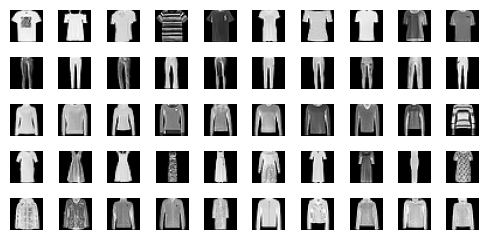

In [23]:
numImagesRows = 5
numImagesCols = len(fmnist_train.classes)

fig, ax = plt.subplots(numImagesRows, numImagesCols, figsize=(5,2.5))

for c, r in enumerate(ax):
    labels_match = np.where(train_labels==c)[0]
    for cell in r:
        idx   = np.random.choice(labels_match)
        img   = train_images[idx]
        label = train_labels[idx]
        cell.grid(False)
        cell.axis('off')
        cell.imshow(img, cmap='gray')
plt.tight_layout()

#Dataset Class

In [24]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x      = x.float()
        x      = x.view(-1, 28*28)
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        return x.to(device), y.to(device)

# Training Data Loader

In [25]:
def get_data_loader():
    train_ds = FMNISTDataset(train_images, train_labels)
    train_dl = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
    return train_dl

# ANN Model

In [27]:
def get_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fun  = nn.CrossEntropyLoss()
    optimizer = SGD(params=model.parameters(), lr=1e-3)
    return model, loss_fun, optimizer

In [32]:
summary(get_model()[0])

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            785,000
├─ReLU: 1-2                              --
├─Linear: 1-3                            10,010
Total params: 795,010
Trainable params: 795,010
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            785,000
├─ReLU: 1-2                              --
├─Linear: 1-3                            10,010
Total params: 795,010
Trainable params: 795,010
Non-trainable params: 0

#Train Batch

In [33]:
def train_batch(x, y, model, loss_fun, optimizer):
    model.train()
    prediction = model(x)
    batch_loss = loss_fun(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

#Accuracy

In [34]:
@torch.no_grad
def accuracy(x, y, model):
    model.eval()
    prediction        = model(x)
    max_vals, argmaxs = prediction.max(-1)
    is_correct        = argmaxs == y
    return is_correct.cpu().numpy().tolist()

#Train

In [35]:
train_dl                        = get_data_loader()
model, loss_function, optimizer = get_model()

In [36]:
losses     = []
accuracies = []
for epoch in range(50):
    print(f"Epoch: {epoch}")
    epoch_losses     = []
    epoch_accuracies = []
    for idx, batch in enumerate(iter(train_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, loss_function, optimizer)
        epoch_losses.append(batch_loss)
    epoch_loss = np.array(epoch_losses).mean()
    for idx, batch in enumerate(iter(train_dl)):
        x, y = batch
        batch_acc = accuracy(x, y, model)
        epoch_accuracies.append(batch_acc)
    epoch_acc = np.array(epoch_accuracies).mean()
    losses.append(epoch_loss)
    accuracies.append(epoch_acc)
    print(f"Loss: {epoch_loss}\tAccuracy: {epoch_acc}")

Epoch: 0
Loss: 1.0688473051985106	Accuracy: 0.8597666666666667
Epoch: 1
Loss: 0.40190405248999594	Accuracy: 0.8604166666666667
Epoch: 2
Loss: 0.3543391483922799	Accuracy: 0.8816
Epoch: 3
Loss: 0.3232818932890892	Accuracy: 0.8854166666666666
Epoch: 4
Loss: 0.29959741751750313	Accuracy: 0.9028833333333334
Epoch: 5
Loss: 0.2830213884408275	Accuracy: 0.9036333333333333
Epoch: 6
Loss: 0.2681260362197955	Accuracy: 0.9061666666666667
Epoch: 7
Loss: 0.2557651441494624	Accuracy: 0.9136666666666666
Epoch: 8
Loss: 0.24424769535859425	Accuracy: 0.9166
Epoch: 9
Loss: 0.235203830503424	Accuracy: 0.9174333333333333
Epoch: 10
Loss: 0.22296653823554516	Accuracy: 0.9231
Epoch: 11
Loss: 0.21768408146500587	Accuracy: 0.9145333333333333
Epoch: 12
Loss: 0.20877851924697557	Accuracy: 0.9318333333333333
Epoch: 13
Loss: 0.20293506413549184	Accuracy: 0.9301666666666667
Epoch: 14
Loss: 0.19458378319690625	Accuracy: 0.9319833333333334
Epoch: 15
Loss: 0.18911443215658266	Accuracy: 0.9345833333333333
Epoch: 16
Loss

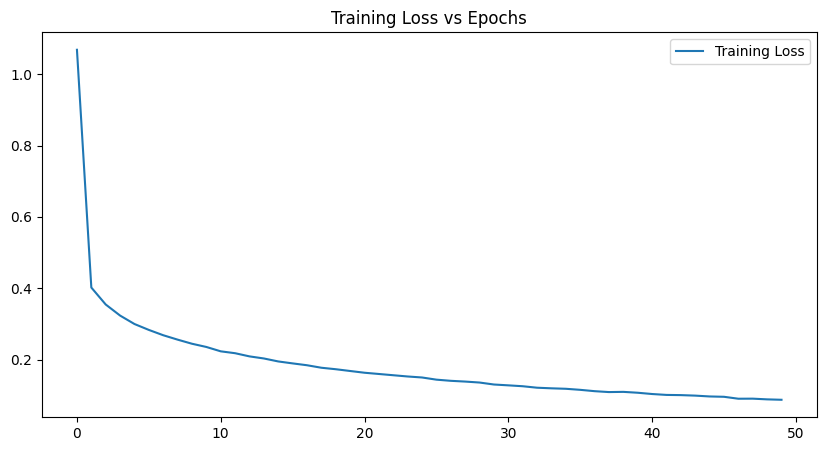

In [38]:
epochs = np.arange(50)
plt.figure(figsize=(10,5))
plt.title("Training Loss vs Epochs")
plt.plot(epochs, losses, label='Training Loss')
plt.legend()

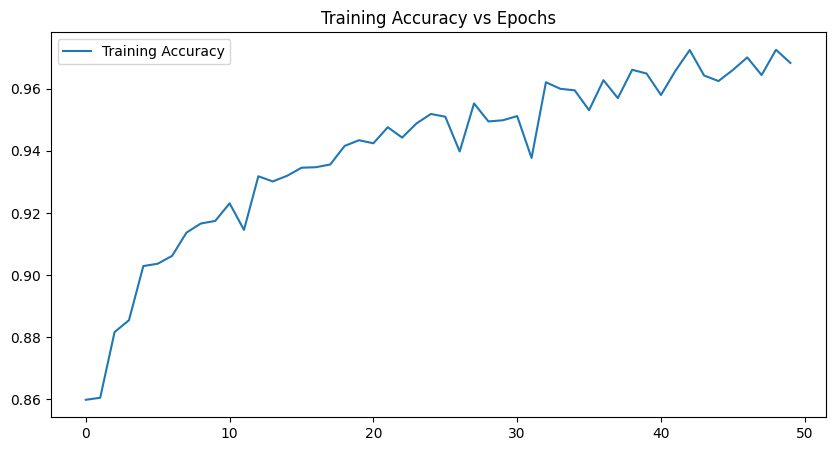

In [39]:
plt.figure(figsize=(10,5))
plt.title("Training Accuracy vs Epochs")
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.legend()